In [1]:
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

data_path = "data"

def configura():
    return None
configura.train_path = "data/yellow_tripdata_2022-01.parquet"
configura.test_path = "data/yellow_tripdata_2022-02.parquet"

configura.categorical = ['PULocationID', 'DOLocationID']

### Preparacion de datos:

In [2]:
def process_df(train=False):
    # leer los datos
    data_path = f"{configura.train_path}" if train else f"{configura.test_path}"
    df = pd.read_parquet(data_path) 
    print(f"forma crudo: {df.shape}")
    # conseguir el objectivo
    df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60
    print(f"desviacion estandar: {df.duration.std()}")
    # cortar delineadores
    sh = len(df)
    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()
    print(f"el compartir tras cortar delineadores {len(df)/sh}")

    # coficar las variables categoricas
    df[configura.categorical] = df[configura.categorical].fillna(-1).astype('int')
    df[configura.categorical] = df[configura.categorical].astype(str)
    dicts = df[configura.categorical].to_dict(orient='records')
    
    if train:
        configura.dv = DictVectorizer()
        configura.dv.fit(dicts)
    
    x = configura.dv.transform(dicts)
    y = df.duration.values
    print(f"dimensionalidad de datos: {x.shape, y.shape}")
    
    return x,y

In [3]:
print("train:")
xtr, ytr = process_df(True)
print("test:")
xts, yts = process_df()

train:
forma crudo: (2463931, 19)
desviacion estandar: 46.44530513776499
el compartir tras cortar delineadores 0.9827547930522406
dimensionalidad de datos: ((2421440, 515), (2421440,))
test:
forma crudo: (2979431, 19)
desviacion estandar: 47.26394076781901
el compartir tras cortar delineadores 0.979444397269143
dimensionalidad de datos: ((2918187, 515), (2918187,))


### Ajuste y evaluacion del modelo (lineal vs booster):

In [4]:
def evaluate_model(model, x, y, train=False):
    mode = "train" if train else "validation" 
    print(f"evaluando modelo {model.__name__} con los datos de {mode}")
    if train:
        configura.model = model()
        configura.model.fit(x, y)
    ypr = configura.model.predict(x)

    print(f"error medio cuadrado: {mean_squared_error(y, ypr, squared=False)}")

    return model, ypr

In [18]:
model, ypr = evaluate_model(LinearRegression, xtr, ytr, True)
print()
model, ypr = evaluate_model(LinearRegression, xts, yts)

evaluando modelo LinearRegression con los datos de train
error medio cuadrado: 6.986190841034851

evaluando modelo LinearRegression con los datos de validation
error medio cuadrado: 7.786408695263233


<Axes: ylabel='Count'>

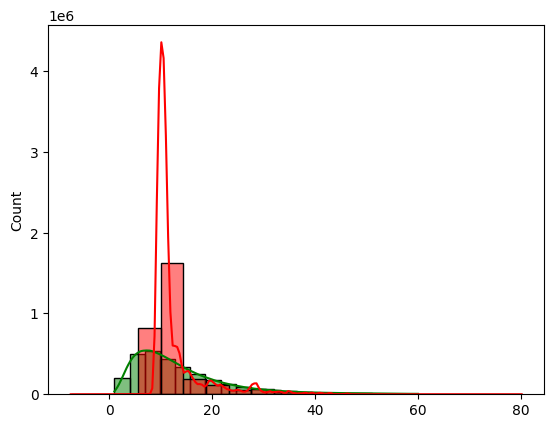

In [19]:
sns.histplot(x=yts, kde=True, color='green', bins=20 ,alpha=0.5)
sns.histplot(x=ypr, kde=True, color='red', bins=20 ,alpha=0.5)

In [20]:
model, ypr = evaluate_model(XGBRegressor, xtr, ytr, True)
print()
model, ypr = evaluate_model(XGBRegressor, xts, yts)

evaluando modelo XGBRegressor con los datos de train
error medio cuadrado: 6.407957119404122

evaluando modelo XGBRegressor con los datos de validation
error medio cuadrado: 7.269462424996284


<Axes: ylabel='Count'>

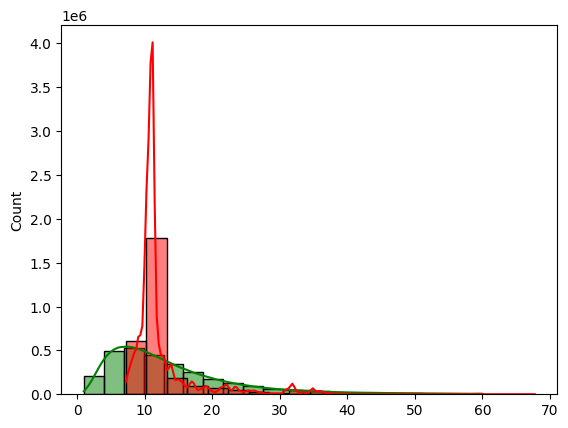

In [21]:
sns.histplot(x=yts, kde=True, color='green', bins=20 ,alpha=0.5)
sns.histplot(x=ypr, kde=True, color='red', bins=20 ,alpha=0.5)